#### <a id='top'></a>

# Creating a Model for a Players Wins Contributed Above Average

***
## Step 1: Create a Model that relates Net Goals Scored to Wins for teams
***

### In baseball the run differential (runs scored - runs given up) is often used as a solid estimator for how many games a team has won. So here I plan on seeing if there is a similarly strong correlation between net goals and wins in hockey because we need a model to help us convert a player's contributed goal differential to estimated wins contributed.

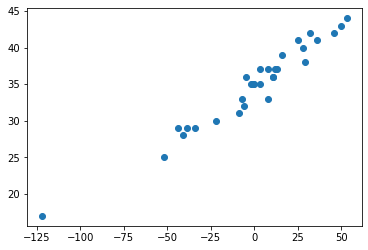

In [31]:
#Load code dependancies
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.api as sm
%matplotlib inline

#Load the Data Set (already cleaned)
teamsdata = pd.read_csv('teams.csv', sep='\t');

#Create net goals
teamsdata['NG'] = teamsdata['GF'] - teamsdata['GA']

#As you can see there is a clear and very linear correlation between goals for and wins
plt.scatter(teamsdata['NG'], teamsdata['W'])

### As it turns out the goal differential appears to correlate very very strongly with wins. Next I will plug this data into statsmodels.api OLS method which will fit a model to this data using the Ordinary Least Squares methodology which is fairly standard when creating a linear regression model. This will also give use data about the fit that can help us decide if the model is precise enough to be useful in estimating how many wins a player has contributed to a team.

In [32]:
#fit a model using Ordinary least squares

X = sm.add_constant(teamsdata['NG'])

model = sm.OLS(teamsdata['W'], X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     546.7
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           2.29e-20
Time:                        03:28:33   Log-Likelihood:                -51.860
No. Observations:                  31   AIC:                             107.7
Df Residuals:                      29   BIC:                             110.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.9032      0.239    145.803      0.000      34.414      35.393
NG             0.1609      0.007     23.382      0.000       0.147       0.175
==============================================================================
Omnibus:                        1.163   Durbin-Watson:                   1.410
Prob(Omnibus):                  0.559   Jarque-Bera (JB):                0.910
Skew:                          -0.407   Prob(JB):                        0.635
Kurtosis:                       2.799   Cond. No.                         34.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### It turns out goal differential is insanely good at predicting wins, with 95% of win totals being explained by our model according to our $R^2$ statistic. Additionally the p value for both our constant and our variable (net goals) as well as the P>|F| (essentially a p-value for both our constant and variable) are insanely low and statistically significant beyond a shadow of a doubt.

### Using the values above we can now show our model as the function 

### $$TeamWins \approx 34.9032 + 0.1608 * TeamNetGoals$$

### Now for fun lets lot this function alongside the scatter plot

In [44]:
#Create the function in a way it can be added to a plot

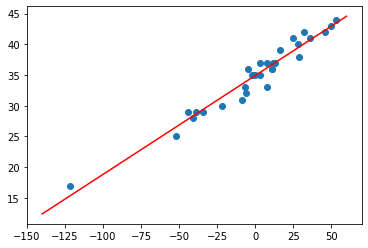

In [33]:
x = np.linspace(-140,60,100)
y = 34.903 + 0.1609*x;

plt.scatter(teamsdata['NG'], teamsdata['W'])
plt.plot(x, y, '-r')

***
## Step 2: Attribute offensive production
***

### Luckily there is already an amazing stat for this in hockey called Goals Created, which is calculated using goals and assists, and the sum of the goals created for all players on a team is equal to the total number of goals scored by this team which makes it almost perfect for us out of the box.

### However once we have testing set up and other larger hurdles figured out we may want to revisit this and see if we can make something that attributes offensive goals cotnributed even more accurately.

***
## Step 3: Attribute Defensive Production
***

### This is a much larger challenge, right now we are taking multiple approaches, the approach I am taking involves looking through important defensive metrics and adding them into a Multiple Linear Regression model and cutting out whatever statistics are least significant until we have a model that is accurate enough to be useful.

### To achieve this I am finding aggregate stats for the teams and trying to model them to goals allowed, if we can do this accurately we can then apply the same thing on a smaller scale for the players.

### For example let us say we have 2 stats A and B that achieve an $R^2$ value of at least .90 (%90 of data being explained by the model) and it is found that the model is 

### $$TeamGoalsAllowed \approx Constant + coefficient*TeamA + coefficient*TeamB$$

### We Could then apply that to players as we have now modeled the relationship between A + B and Goals allowed so we would use

### $$PlayerGoalsAllowed \approx Constant + coefficient*PlayerA + coefficient*PlayerB$$

### First we need to load in important data to use, aggregate it on a team level, and add to the team dataframe, I start by looking at Hits and Blocks, but also load in +/- which we will be using later

In [34]:
#Load in player data
playersdata = pd.read_csv('players.csv', sep=',')

#Get rid of goalies from data bc their stats are very very different
playersdata = playersdata[playersdata.Pos != 'G']

#Get rid of anyone who was traded as we cannot yet account for that, may want to look into later to improve accuracy
playersdata = playersdata[playersdata.Tm != 'TOT']

#Players aggregated data on defensive metrics by team
playersagg = playersdata[['Tm', 'HIT', 'BLK', '+/-']].copy()
aggregate_functions = {'+/-': 'mean', 'HIT' : 'mean', 'BLK': 'mean'}
playersagg = playersagg.groupby(playersagg['Tm'], as_index=False).aggregate(aggregate_functions)

#find the total number of blocks for each team
teamsdata = teamsdata.sort_values('Name')
teamsdata['+/-'] = 0
teamsdata['HIT'] = 0
teamsdata['BLK'] = 0
i = 0
while(i < 31):
    j = 0
    while(j < 31):
        if(teamsdata['Name'][i] == playersagg['Tm'][j]):
            teamsdata['+/-'][i] = playersagg['+/-'][j]
            teamsdata['HIT'][i] = playersagg['HIT'][j]
            teamsdata['BLK'][i] = playersagg['BLK'][j]
        j+=1
    i += 1

<ipython-input-34-fe6bba670b76>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teamsdata['+/-'][i] = playersagg['+/-'][j]
<ipython-input-34-fe6bba670b76>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teamsdata['HIT'][i] = playersagg['HIT'][j]
<ipython-input-34-fe6bba670b76>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teamsdata['BLK'][i] = playersagg['BLK'][j]


### Now let us apply OLS Multiple Regression and see if Hits and Blocks can be used to accurately estimate goals given up

In [35]:
X = sm.add_constant(teamsdata[['HIT', 'BLK']])

model = sm.OLS(teamsdata['NG'], X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     NG   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.069
Method:                 Least Squares   F-statistic:                   0.03237
Date:                Thu, 01 Apr 2021   Prob (F-statistic):              0.968
Time:                        03:28:45   Log-Likelihood:                -153.98
No. Observations:                  31   AIC:                             314.0
Df Residuals:                      28   BIC:                             318.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3076     23.330      0.013      0.990     -47.482      48.097
HIT           -0.2172      0.882     -0.246      0.807      -2.023       1.589
BLK            0.3277      1.355      0.242      0.811      -2.448       3.103
==============================================================================
Omnibus:                       14.356   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.738
Skew:                          -1.220   Prob(JB):                     0.000232
Kurtosis:                       5.646   Cond. No.                         200.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### according to our $R^2$ this model can only account for 2% of our data and none of our parameters are statistically significant, clearly we need to search more and find a model that actually works as neither HITS or BLOCKS alone reveal much, perhaps we could use another defensive metric or account for different amounts of time on ice by cratig a HITS/Minute or BLOCKS/Minute statistic.

***
## Step 4: Caclulate a players net goals contributed
***

### The formula for this is quate straight forward 

### $$NetGoalsContributed = GoalsCreated - GoalsAllowed$$

### Since we do not have a working GoalsAllowed model I will be using the +/- hockey stat in it's stead, +/- is a measure of the net goals the team has recieved while the player is on the ice so it will appear to work well for our purposes but is not appropraite for our final solution as +/- is directly affected by team performance, and we are ultimately looking for player performance.

### As you can see below average +/- is a pretty accurate way to estimate a teams goals allowed

In [26]:
X = sm.add_constant(teamsdata['+/-'])

model = sm.OLS(teamsdata['NG'], X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     NG   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     200.8
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           1.45e-14
Time:                        03:27:28   Log-Likelihood:                -121.93
No. Observations:                  31   AIC:                             247.9
Df Residuals:                      29   BIC:                             250.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9536      2.304      1.282      0.210      -1.759       7.667
+/-            8.3239      0.587     14.170      0.000       7.122       9.525
==============================================================================
Omnibus:                        0.251   Durbin-Watson:                   2.219
Prob(Omnibus):                  0.882   Jarque-Bera (JB):                0.030
Skew:                           0.075   Prob(JB):                        0.985
Kurtosis:                       2.966   Cond. No.                         3.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

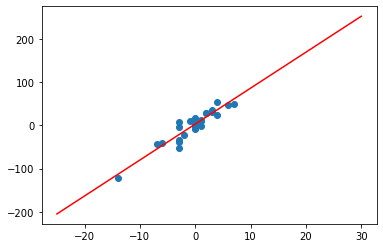

In [27]:
x = np.linspace(-25,30,100)
y = 2.9536 + 8.3239*x;

plt.scatter(teamsdata['+/-'], teamsdata['NG'])
plt.plot(x, y, '-r')

***
## STEP 5: Find Net Goals Above Average
***

### For this since a player can only replace a player of the same position we will calculate net goals above average with the average being the average net goals at the players position.

### $$NetGoalsAboveAverage = NetGoalsContributed - PositionMeanGoalsContributed$$

***
## STEP 6: Find Wins Above Average
***

### $$WinsAboveAverage = WAA = Wins(NetGoalsAboveAverage)$$

***
## Step 7: Test for accuracy
***

### I have some basic tests belowm these will need to be updated

In [28]:
mean_pm = playersdata['+/-'].mean()

pm = 31;

mean_wins = (mean_pm * 0.2411 + 3.857) + 34.904
wins = (pm * 0.2411 + 3.857) + 34.904

winsAboveAverage = wins - mean_wins;

print(winsAboveAverage)

7.56714279705573


In [29]:
mean_wins = teamsdata['W'].mean()

#WAA = Wins above Average expected for whole team
teamsdata['WAAexpected'] = ((teamsdata['+/-'] * 0.2411 + 3.857) + 34.904) - mean_wins
teamsdata['WAAactual'] = teamsdata['W'] - mean_wins
teamsdata['WAAerror'] = teamsdata['WAAexpected'] - teamsdata['WAAactual'];

print(teamsdata['WAAerror'].mean())

3.7722225806451637
